# Historical graphing
A first ever attempt at pulling in data from the web and then graphing it 

In [1]:
# V2 plan
#  want to make the analysis bit a function so I can have returns of all of them available- done
#  put in portfolio- find optimal- done  
#  find risk contribution.
#  put in rebalancing ability
#  make interactive graph- done

In [2]:
# load some libraries
import pandas as pd
import numpy as np
#next line seems necessary atm based on https://stackoverflow.com/questions/50394873/import-pandas-datareader-gives-importerror-cannot-import-name-is-list-like
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from ipywidgets import interact
%matplotlib inline

In [3]:
#loading data from website
start_dt = '2000-1-1'

# I couldn't get yahoo or google to work so I had to use 'fred'
spx = web.DataReader(name='SP500', data_source='fred',start = start_dt).dropna()
vix = web.DataReader(name='VIXCLS', data_source='fred',start = start_dt).dropna()
us_hy = web.DataReader(name='BAMLHYH0A0HYM2TRIV', data_source='fred',start = start_dt).dropna()
us_ig = web.DataReader(name='BAMLCC0A0CMTRIV', data_source='fred',start = start_dt).dropna()

#combine into a single dataframe and summarise it
markets = pd.concat([spx,vix,us_hy,us_ig], axis=1).dropna()
markets.columns = ['spx', 'vix','us_hy','us_ig']
markets.describe()

,spx,vix,us_hy,us_ig
count,2515.000000,2515.000000,2515.000000,2515.000000
mean,1779.903316,18.271022,975.940667,2427.250493
std,564.862409,7.229690,209.895860,350.564165
min,676.530000,9.140000,424.720000,1521.770000
25%,1287.040000,13.270000,818.280000,2162.780000
50%,1833.320000,16.230000,1011.530000,2474.080000
75%,2138.140000,21.120000,1123.875000,2735.750000
max,2930.750000,52.650000,1297.010000,2910.770000


In [4]:
def return_calcs(market):
    'formula which takes in dataframe of index level, returns dataframe with returns, MAs and volatilty'
    market.columns = ['level']
    market['return'] = np.log(market['level']/market['level'].shift(1))
    market['30D'] = market['level'].rolling(window=30).mean()
    market['90D'] = market['level'].rolling(window=90).mean()
    market['90-30'] = market['90D'] - market['30D']
    market['vol'] = market['return'].rolling(window=60).std()*np.sqrt(252)
    return market

#list of markets used
market_list = [spx,vix,us_hy,us_ig]

# loop through all the different markets and do the same calcs
for i in range(len(market_list)):
    return_calcs(market_list[i])

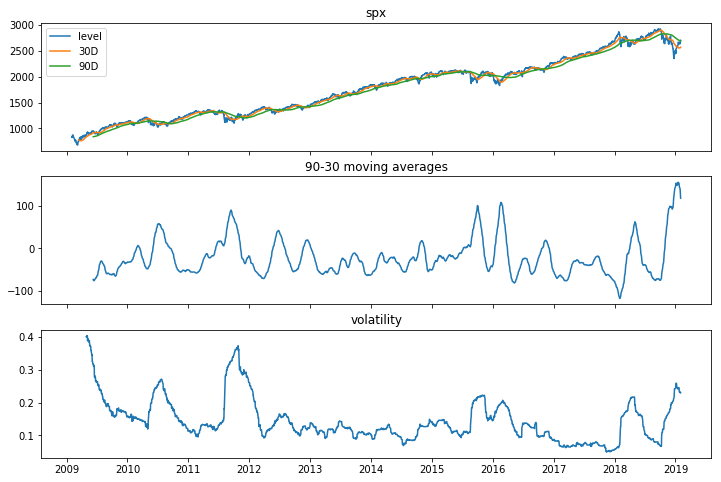

In [5]:
# choose a market to graph i=[0-spx, 1- vix, 2-us_ig, 3-us_hy]
i = 0

#Creates subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,sharex=True,figsize=(12,8))
ax1.plot(market_list[i]['level'])
ax1.plot(market_list[i]['30D'])
ax1.plot(market_list[i]['90D'])
ax1.legend()
ax1.set_title(markets.columns[i])
ax2.plot(market_list[i]['90-30'])
ax2.set_title('90-30 moving averages')
ax3.plot(market_list[i]['vol'])
ax3.set_title('volatility');

## Simple linear regression

In [6]:
#choose what will be regressed [0-spx, 1- vix, 2-us_ig, 3-us_hy]
x = 0
y = 1

returns = pd.concat([market_list[x]['return'],market_list[y]['return']], axis=1).dropna()
returns.columns = [markets.columns[x],markets.columns[y]]
model = sm.OLS(returns.iloc[:,0].values,sm.add_constant(returns.iloc[:,1].values))
results = model.fit()
#print(results.summary())

Text(0.5,1,'regression results')

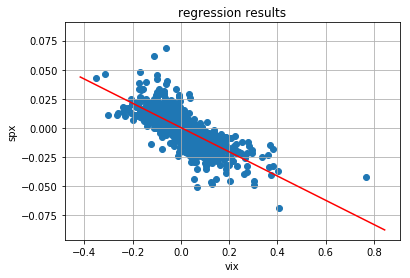

In [7]:
plt.scatter(returns.iloc[:,1].values,returns.iloc[:,0].values)
ax = plt.axis()
lin_x = np.linspace(ax[0],ax[1]+0.01)
plt.plot(lin_x,results.params[0]+results.params[1]*lin_x,c='r')
plt.grid(True)
plt.axis('tight')
plt.xlabel(markets.columns[y])
plt.ylabel(markets.columns[x])
plt.title('regression results')

## Portfolio Construction and mean variance optimisation

In [8]:
#overwrite the returns dataframe with all of them, take a look at the correlations
returns = pd.concat([market_list[0]['return'],market_list[1]['return'],
                     market_list[2]['return'],market_list[3]['return']], axis=1).dropna()
returns.columns = [markets.columns[0],markets.columns[1],markets.columns[2],markets.columns[3]]
returns.corr()

,spx,vix,us_hy,us_ig
spx,1.000000,-0.763845,0.359856,-0.303876
vix,-0.763845,1.000000,-0.297674,0.237462
us_hy,0.359856,-0.297674,1.000000,0.118958
us_ig,-0.303876,0.237462,0.118958,1.000000


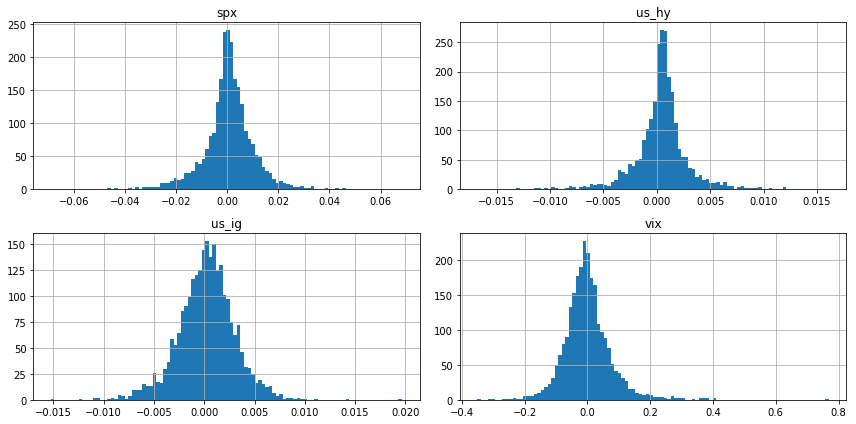

In [9]:
returns.hist(bins=100,figsize=(12,6));
plt.tight_layout()

Create some functions to help with optimisation, find max sharpe ratio

In [10]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array of return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(returns.mean() * weights) * 252 #annualised return
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))) #annualised vol
    sr = ret/vol
    return np.array([ret,vol,sr])

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

opt_results

     fun: -2.7627402154168776
     jac: array([-0.00021929,  0.00526932,  0.00010264, -0.000395  ])
 message: 'Optimization terminated successfully.'
    nfev: 72
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.0830774 , 0.01183947, 0.63042045, 0.27466268])

Generate some random portfolios, basically just to get a pretty graph at the end

In [11]:
num_ports = 1000

all_weights = np.zeros((num_ports,len(returns.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((returns.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

Find the optimal portfolio at different levels of return- plot the efficient frontier

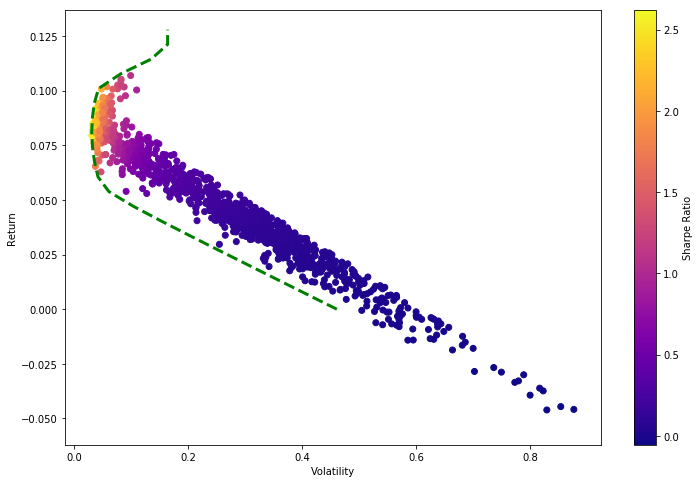

In [12]:
# Create a linspace number of points to calculate x on- from 0 to max asset return +0.01
frontier_y = np.linspace(0,returns.mean().max()*252+0.01,20) # Change 100 to a lower number for slower computers! (Set to 20 for now)

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])
    
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3);

## Play around with an interactive chart

In [13]:
def int_chart(Asset1,Asset2,Asset3):
    labels = 'SPX', 'VIX', 'US HY', 'US IG'
    sizes = [100-Asset1-Asset2-Asset3, Asset1, Asset2, Asset3]
    weights = np.array(sizes)/100
    ret = np.sum(returns.mean() * weights) * 252 #annualised return
    vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))) #annualised vol
    sr = ret/vol
    port_stats = np.array([ret,vol,sr])
    
    explode = (0, 0, 0, 0)  # don't explode anything, can exploded by changing value in that chart
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    print('Portfolio expected return: '+str(round(port_stats[0]*100,1)))
    print('Portfolio expected vol: '+str(round(port_stats[1]*100,1)))
    print('Portfolio expected sharpe ratio: '+str(round(port_stats[2],1)))
    #return port_stats

#bit that interacts
interact(int_chart,Asset1=(0,50),Asset2=(0,50),Asset3=(0,50));

interactive(children=(IntSlider(value=25, description='Asset1', max=50), IntSlider(value=25, description='Asse…